# Reinforcement learning project

## Table of contents

0. [Introduction](#introduction)
    1. Rules
1. [Implementation of Easy21](#paragraph1)
    1. Try the environment
2. [Monte-Carlo Control ](#paragraph2)
    1. Implementation
    2. Best Action Heatmap
    3. V and Q functions
    4. How the states were explored
3. [Sarsa (TD Learning)](#paragraph3)
    1. Implementation
    2. Best Action Heatmap
    3. MSE and convergence
    4. How the states were explored
4. [Sarsa with Linear Function Approximation](#paragraph4)
    1. State update
    2. Try the environment
    3. Implementation
    4. Best Action Heatmap
    5. V and Q functions
    6. MSE and convergence
    7. How the states were explored
5. [Discussion](#paragraph5)


## 0. Introduction <a name="introduction"></a>

We decided to base our Reinforcement Learning project on the <a href='https://www.davidsilver.uk/wp-content/uploads/2020/03/Easy21-Johannes.pdf'>assignment proposed by David Silver</a>, research scientist at DeepMind and a professor at University College London. 

The goal is to apply several reinforcement algorithms to a blackjack variant called easy21.

In addition to the tasks required in the assignment, we decided to go further and look at the best policies or how much states are visited for instance.

The rules of the easy21 game are defined hereunder.

## Rules

* The game is played with an infinite deck of cards (i.e.  cards are sampled with replacement)
* Each draw from the deck results in a value between 1 and 10 (uniformly distributed) with a colour of red (probability: 1/3) or black (probability: 2/3).
* There are no aces or picture (face) cards in this game
* At the start of the game both the player and the dealer draw one black card (fully observed)
* Each turn the player may either stick or hit
* If the player hits then she draws another card from the deck
* If the player sticks she receives no further cards
* The values of the player’s cards are added (black cards) or subtracted (redcards)
* If  the  player’s  sum  exceeds  21,  or  becomes  less  than  1,  then  she  “goes bust” and loses the game (reward -1)
* If the player sticks then the dealer starts taking turns.  The dealer always sticks on any sum of 17 or greater, and hits otherwise.  If the dealer goes bust,  then  the  player  wins;  otherwise,  the  outcome  –  win  (reward  +1), lose (reward -1), or draw (reward 0) – is the player with the largest sum.

In [1]:
import numpy as np
from tqdm import tqdm
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.axes3d import Axes3D
import pandas as pd
import copy

## 1. Implementation of Easy21 <a name="paragraph1"></a>


To implement the game, we created 2 classes:
* State represents a state of the game defined by the player and the dealer scores.
* Easy21World is the interface of the game. Algorithms will mainly interact with it.

In [2]:
class Easy21World:   
    def __init__(self, print_log = False):
        self.s = State() #Dealer deals
        self.isGameOver = False #Status of the game
        if print_log:
            print(self.s)
        
    def step(self, a, print_log = False): 
        '''
        Go to the next (sampled) state and returns the associated reward
        
        Parameters
        ----------
        a : string (or bool)
            Player's action (hit or stick)
        print_log : bool
            Print logs
        Returns
        ----------
        _ : int
            The reward of the game (-1, 0 or 1)
        '''
    
        if (a == 1 or a == "hit"): # a=1 reprensents the action 'hit'
            if print_log:
                print("Player hits")
                
            # Player hits    
            self.s.hit("player", print_log)
            
            if print_log:
                print(self.s)
            
            # Check if the player goes busted
            if(self.s.isBusted("player")):
                self.isGameOver = True
                return -1
            else:
                return 0
            
        elif (a == 0 or a == "stick"): #0 = Stick
            if print_log:              
                print("Player sticks")
                
            # Dealer plays
            self.isGameOver = True
            self.s.dealer_play(print_log)
            
            if print_log:
                print(self.s) 
                
            # Define the outcome
            if self.s.isBusted("dealer") or self.s.player_score > self.s.dealer_score:
                return 1           
            elif self.s.player_score < self.s.dealer_score:
                return -1 
            else:
                return 0
        
        else:
            print("The action should be chosen between 'hit' and 'stick'.")            
                
class State:
    def __init__(self):
        self.player_score = np.random.randint(1, 10+1)
        self.dealer_score = np.random.randint(1, 10+1)
        
    def __str__(self):
        return "{'player_score': " + str(self.player_score) + ", 'dealer_score': " + str(self.dealer_score) + "}"
    
    def isBusted(self, participant):      
        '''Check if the participant is busted
        
        Parameters
        ----------
        participant : string
            "player" or "dealer"
        Returns
        ----------
        _ : bool
            True if participant's score is lower than 1 or higher than 21
        '''
        
        if (participant == "player"):
            return ( (self.player_score < 1) + (self.player_score > 21) ) >= 1
        elif (participant == "dealer"):
            return ( (self.dealer_score < 1) + (self.dealer_score > 21) ) >= 1
        else:
            print("The participant should be either 'player' or 'dealer'")        
        
    def hit(self, participant, print_card = False):
        '''Draw a card for the participant
        
        Parameters
        ----------
        participant : string
            "player" or "dealer"
        print_card : bool
            Print logs
        '''
        
        if (participant == "player"):
            self.player_score += self.draw(print_card)
        elif (participant == "dealer"):
            self.dealer_score += self.draw(print_card)
        else:
            print("The participant should be either 'player' or 'dealer'")

    def dealer_play(self, print_card):
        '''Play the dealer's turn
        
        Parameters
        ----------
        print_card : bool
            Print logs
        '''
              
        while(self.dealer_score < 17):
            self.hit("dealer", print_card)
            if self.isBusted("dealer"):
                break
               
    @staticmethod           
    def draw(print_card):
        '''Define the value of a drawn card
        
        Parameters
        ----------
        print_card : bool
            Print logs
            
        Returns
        ----------
        card_value : int
            Value of the card
        '''            
            
        color_value = -1 if np.random.rand() < 1 / 3 else 1
        card_value = color_value * np.random.randint(1, 10+1)
        if print_card:
            print("The drawn card has a value of", card_value)
        return card_value

Now that we have implemented our environment, let's play with it!

### Try the environment

In [3]:
np.random.seed(1801)

We deal the cards.

In [4]:
env = Easy21World(print_log = True)

{'player_score': 5, 'dealer_score': 3}


We decide to hit a few times

In [5]:
env.step("hit", print_log = True)

Player hits
The drawn card has a value of 5
{'player_score': 10, 'dealer_score': 3}


0

In [6]:
env.step("hit", print_log = True)

Player hits
The drawn card has a value of 7
{'player_score': 17, 'dealer_score': 3}


0

We think 17 is enough, now let's stick.

In [7]:
env.step("stick", print_log = True)

Player sticks
The drawn card has a value of -6
{'player_score': 17, 'dealer_score': -3}


1

Dealer went busted, we won!

In [8]:
env.isGameOver

True

## 2. Monte-Carlo Control <a name="paragraph2"></a>

### Implementation

To find the best policy, we start with a **Monte-Carlo algorithm** to estimate the q function. We combine this with an **$\epsilon$-greedy exploration** strategy. Once the optimum is reached, we can determine our optimal policy.

<img src="img/MC_pseudo_algorithm_2.png" width=600>

In [9]:
def epsilon_greedy(N_0, N, Q, player_score, dealer_score):
    '''Determines which action should be played

    Parameters
    ----------
    N_0 : int
        Exploration parameter
    N : np.array(int)
        Number of time each state N[p,d,a] has been visited
    Q : np.array
        Q-function
    player_score : int
        Player's score
    dealer_score : int
        Dealer's score
        
    Returns
    ----------
    action : bool
        Value of the action to be played
    '''
    
    action = "None"
    if np.random.random() < N_0 / (N_0 + np.sum(N[player_score - 1, dealer_score - 1 , :])):
        action = np.random.randint(0, 1+1)
    else:
        action = np.argmax(Q[player_score - 1, dealer_score - 1, :])
    return action

def mc_control(num_episodes, N_0, gamma):
    '''Implements Monte-Carlo algorithm
    
    Parameters
    ----------
    num_episode : int
        Number of episodes
    N_0 : int
        Exploration parameter
    gamma : float
        Update parameter
        
    Returns
    ----------
    Q : np.array
        Q-function
    N : np.array(int)
        Number of time each state N[p,d,a] has been visited
    '''    

    # Initialize empty arrays
    Q = np.zeros([21, 10, 2])
    N = np.zeros([21, 10, 2])
    
    for _ in tqdm(range(num_episodes)):
        # Initiliaze the history
        history = []
        
        # Create a new environment
        env = Easy21World()
        
        # Infinite loop
        while True:   

            # Get current state
            player_score = env.s.player_score
            dealer_score = env.s.dealer_score 
            
            # Choose an action          
            action = epsilon_greedy(N_0, N, Q, player_score, dealer_score)
                        
            # Run one timestep of the environment's dynamics
            reward = env.step(action)  
            
            # Add the experience to the history   
            history.append((player_score, dealer_score, action, reward))
            
            # If terminal state then break the look
            if env.isGameOver:
                break
                
        # Update the knowledge
        Gt = 0
        for (player_score, dealer_score, action, reward) in reversed(history):
            N[player_score - 1, dealer_score - 1, action] += 1
            alpha = 1 / N[player_score - 1, dealer_score - 1, action]
            Gt = gamma * Gt + reward
            Q[player_score - 1, dealer_score - 1, action] += alpha * (Gt - Q[player_score - 1, dealer_score - 1, action])
                
    return Q, N



Let's try our MC algorithm.

In [10]:
mc_Q, mc_N = mc_control(10**6,1000, 1)

100%|██████████████████████████████████████████████████████████████████████| 1000000/1000000 [02:18<00:00, 7221.93it/s]


In [11]:
def compute_df(Q):
    '''Creates a dataframe with information concerning v* and q.
    
    Parameters
    ----------
    Q : np.array
        Q-function
        
    Returns
    ----------
    df : pd.DataFrame
        Dataframe with the value of v*, q0 (q for action == 0), q1 (q for action == 1) 
        for each triplet (player's score, dealer's score, action)
    '''  
    A_star = Q.argmax(axis=2)
    V_star = np.amax(Q, axis=2)
    df = pd.DataFrame(columns=['player', 'dealer', 'a', 'v_star', 'q0', 'q1'])

    for p in range(1, 21 + 1):
        for d in range(1, 10 + 1):
            df = df.append( {'player': p, 
                             'dealer': d, 
                             'a' : A_star[p - 1, d - 1],  
                             'v_star': V_star[p - 1,d - 1],
                             'q0': Q[p - 1, d - 1, 0],
                             'q1': Q[p - 1, d - 1, 1],                                              
                            },ignore_index = True )
            
    df[["player", "dealer", "a"]] = df[["player", "dealer", "a"]].astype(int)

    return df

In [12]:
mc_df = compute_df(mc_Q)
mc_df

,player,dealer,a,v_star,q0,q1
0,1,1,0,0.300383,0.300383,-0.117030
1,1,2,0,0.257545,0.257545,-0.210788
2,1,3,0,0.209132,0.209132,-0.270206
3,1,4,0,0.158042,0.158042,-0.293160
4,1,5,0,0.114664,0.114664,-0.269868
...,...,...,...,...,...,...
205,21,6,0,0.936364,0.936364,-0.745763
206,21,7,0,0.955056,0.955056,-0.661538
207,21,8,0,0.905263,0.905263,-0.692308
208,21,9,0,0.929936,0.929936,-0.789063


The first thing we all want to know is what is the best action to play depending on the state we are?

Let's figure this out!

### Best Action Heatmap

In [13]:
def display_best_action_heatmap(Q, title=""):
    '''Creates a heatmap showing which action is most profitable for each state
    
    Parameters
    ----------
    Q : np.array
        Q-function
    ''' 
    A_star = Q.argmax(axis=2)

    plt.figure(figsize=(6,6))
    plt.imshow(A_star, cmap=plt.cm.get_cmap('hot', 2), extent=[1-0.5, 10+0.5, 1-0.5, 21+0.5], origin='lower') #Black = stick, white = hit
    plt.colorbar(ticks=range(2), label='black = stick, white = hit', shrink = 0.5)
    plt.xticks(np.arange(1, 10+1, 1))
    plt.yticks(np.arange(1, 21+1, 1))

    plt.xlabel("Dealer's score")
    plt.ylabel("Player's score")
    plt.title(title, size=16)
    plt.show()   

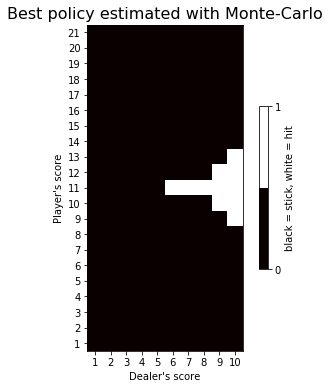

In [14]:
display_best_action_heatmap(mc_Q, title="Best policy estimated with Monte-Carlo")

Most of the time, the best action is to stick, except in a small region.

Let's have a look at:
* v* (defined as $max_a\ Q^*(s,a)$)
* q for both the actions "hit" and "stick"

### V and Q functions

In [15]:
def display_3d_representation(df, column_name, norm_color=True, title=""):
    '''Creates a 3d representation of the "column_name" value
    
    Parameters
    ----------
    df : pd.DataFrame
        Dataframe with the data
    column_name : string
        v_star, q0 or q1
    norm_color : bool
        If True, the range of color is set between -1 and 1.
    ''' 
    
    fig = plt.figure(figsize=(20,10))
    ax = fig.gca(projection='3d')
    if norm_color:
        plot = ax.plot_trisurf(df['dealer'], df['player'], df[column_name], cmap=plt.cm.coolwarm, vmin=-1, vmax=1)
        ax.set_zlim3d(-1,1)
    else:
        plot = ax.plot_trisurf(df['dealer'], df['player'], df[column_name], cmap=plt.cm.coolwarm)
    fig.colorbar(plot, shrink = 0.5)
    ax.view_init(30,-30)
    ax.set_xlabel("Dealer's score", fontsize = 14)
    ax.set_ylabel("Player's score", fontsize = 14)
    
    plt.title(title, size=20)
    
    plt.show()

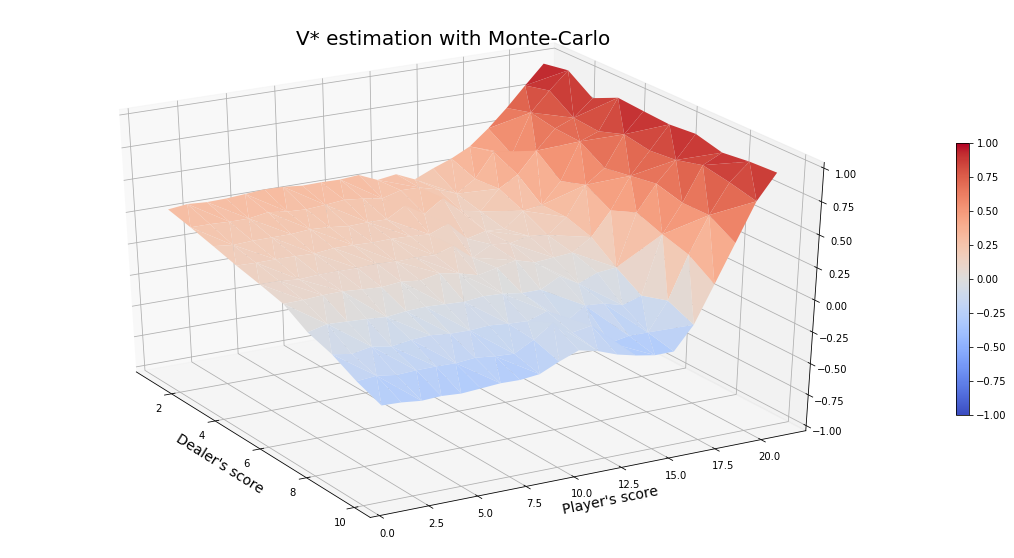

In [16]:
display_3d_representation(mc_df,"v_star",title="V* estimation with Monte-Carlo")

Two aspects are interesting in the graph above:
* We can see that the **best values for V\*** are obtained when the **player's score is high**.
* When the **dealer's score is increasing**, in most of the cases, the value of **V* seems to decrease**.

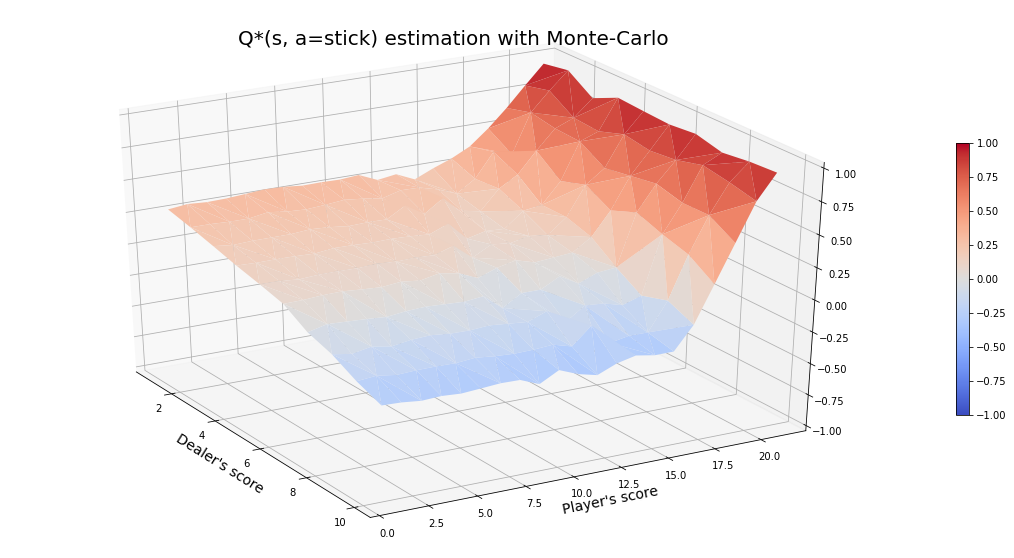

In [17]:
display_3d_representation(mc_df,"q0", title="Q*(s, a=stick) estimation with Monte-Carlo")

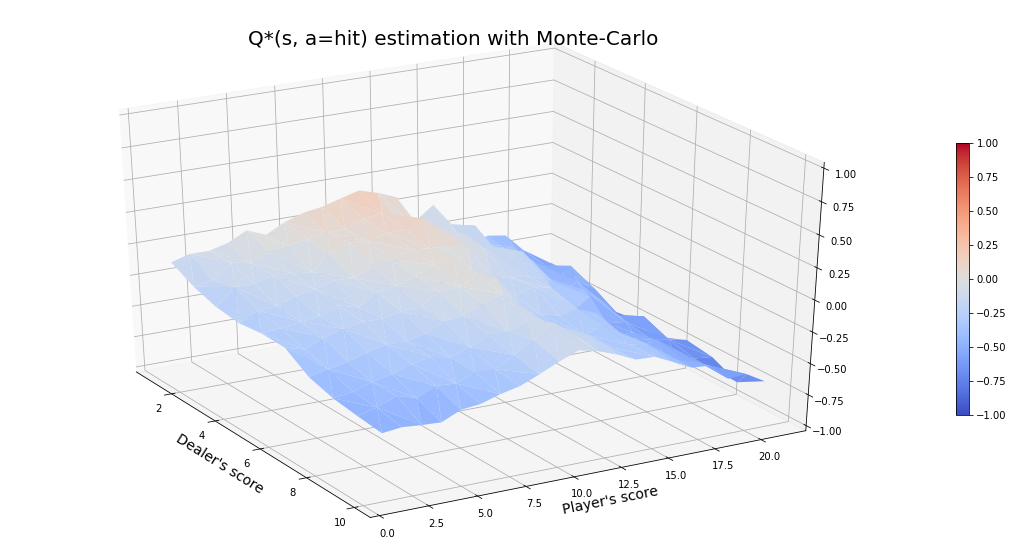

In [18]:
display_3d_representation(mc_df,"q1", title="Q*(s, a=hit) estimation with Monte-Carlo")

Values of q are often higher for the action "stick", especially when the player's score is high. This makes sense since:
* it is a **comfortable position** to be in: it's hard for the dealer to do better.
* choosing to "hit" is taking high risks to go busted.

In the same way, when the player starts with a score of 1, he has a risk of 1/3 to go busted instantly if he draw another card. So the best strategy is to stick, hoping that the dealer will go busted (especially if he also starts with a weak card).

### How the states were explored

Let's be curious and find out what states were the most seen.

In [19]:
def plot_N(N, title=""):
    '''
    Plot a heatmap representing how much states were visited

    Parameters
    ----------
    N : np.array(int)
        Data
    title : str
        Title of the graphic
    '''
    plt.figure(figsize=(6,6))
    plt.imshow(N, cmap=plt.cm.get_cmap('hot'), extent=[1-0.5, 10+0.5, 1-0.5, 21+0.5], origin='lower')
    plt.colorbar(shrink = 0.5)
    plt.xticks(np.arange(1, 10+1, 1))
    plt.yticks(np.arange(1, 21+1, 1))
    plt.xlabel("Dealer's score", size=14)
    plt.ylabel("Player's score", size=14)
    plt.title(title, size=16)
    plt.show()    

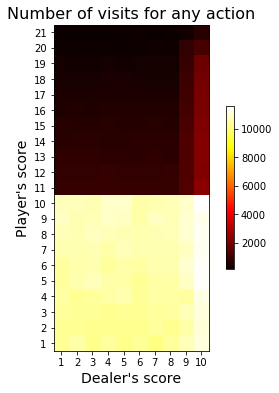

In [20]:
plot_N(np.sum(mc_N,axis=2),"Number of visits for any action")

We see there that, the state with a player's score lower than 10 were more explored. At least two reasons explains this phenomenon:
* For each episode, the **first state has a player's score lower than 10**.
* As we have seen before, the **best strategy is often to stick**.

When we look at the heatmap of the visited states **per action**, we see that what only differs from the previous graphic is the area where the best strategy is to "hit".

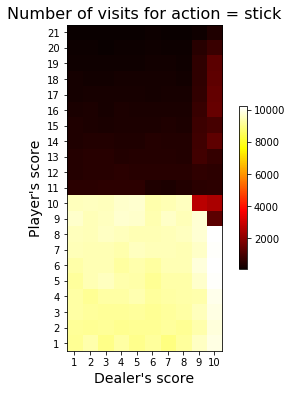

In [21]:
plot_N(mc_N[:,:,0],"Number of visits for action = stick")

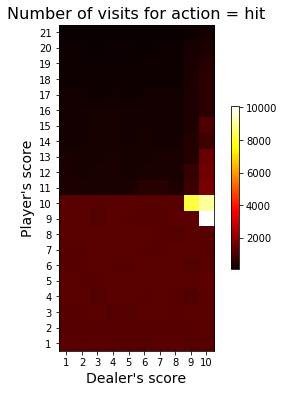

In [22]:
plot_N(mc_N[:,:,1],"Number of visits for action = hit")

## 3. Sarsa (TD Learning) <a name="paragraph3"></a>

### Implementation

To find the best policy, we implement a **Sarsa($\lambda$) algorithm** to estimate the q function. We combine this with a **𝜖-greedy exploration strategy**. Once the optimum is reached, we can determine our optimal policy.

<img src="img/Sarsa_lambda_pseudo_algorithm.png" width=600>

In [23]:
def sarsa_lambda(num_episodes, N_0, gamma, lambda_, mc_Q = None):
    '''Implements Sarsa(lambda) algorithm
    
    Parameters
    ----------
    num_episode : int
        Number of episodes
    N_0 : int
        Exploration parameter
    gamma : float
        Update parameter
    lambda_ : float
        Sarsa parameter
    mc_Q : np.array
        Q-function (computed with MC algorithm)
        
    Returns
    ----------
    Q : np.array
        Q-function
    N : np.array(int)
        Number of times each state N[p,d,a] has been visited
    error_history : list(float)
        Evolution of the MSE (between Q and mc_Q)
    '''     
    # Initialize empty arrays
    Q = np.zeros([21, 10, 2])
    N = np.zeros([21, 10, 2])
    error_history = list()
    
    for i_episode in tqdm(range(num_episodes)):
        #print("EPISODE ",i_episode)
        
        # Initialize E array  
        E = np.zeros([21, 10, 2])
        
        # Create a new environment (initialize S)
        env = Easy21World()

        # Choose first action (initialize A)
        player_score = copy.deepcopy(env.s.player_score)
        dealer_score = env.s.dealer_score 
        action = epsilon_greedy(N_0, N, Q, player_score, dealer_score)  
        
        # Infinite loop
        while True:   
            # Run one timestep of the environment's dynamics (take action A, observe R, S')
            reward = env.step(action)  
            next_player_score = copy.deepcopy(env.s.player_score)
            
            if env.isGameOver:
                next_action = "None"
                delta = reward - Q[player_score - 1, dealer_score - 1, action]
            else:
                # Choose next action A'
                next_action = epsilon_greedy(N_0, N, Q, next_player_score, dealer_score)

                # Compute delta
                delta = reward \
                        + gamma * Q[next_player_score - 1, dealer_score - 1, next_action] \
                        - Q[player_score - 1, dealer_score - 1, action]

            # Increment E
            E[player_score - 1, dealer_score - 1, action] += 1
            
            # Update the knowledge
            # For each state and action, compute the new values of Q and E
            N[player_score - 1, dealer_score - 1, action] += 1
            alpha = 1 / N[player_score - 1, dealer_score - 1, action]
            
            for p in range(1, 21 + 1):
                for a in range(1 + 1):
                    Q[p - 1, dealer_score - 1, a] += alpha * delta * E[p - 1, dealer_score - 1, a]
                    E[p - 1, dealer_score - 1, a] *= gamma * lambda_
  
            # If terminal state then break the look
            if env.isGameOver:
                break

            # Update next action and next player_score
            player_score = copy.deepcopy(next_player_score)
            action = next_action
        
        # Add error_history
        if (mc_Q is not None):
            error_history.append(np.mean((Q - mc_Q)**2)) 
    
    if (mc_Q is not None):
        return Q, N, error_history
    
    return Q, N



### Best Action Heatmap

Let us compute a Sarsa(0.2) and look at the best policy it produces!

In [24]:
lambda_ = 0.2
sarsa_Q, sarsa_N = sarsa_lambda(num_episodes = 10**6, N_0 = 100, gamma = 1, lambda_ = lambda_)

100%|██████████████████████████████████████████████████████████████████████| 1000000/1000000 [05:22<00:00, 3103.05it/s]


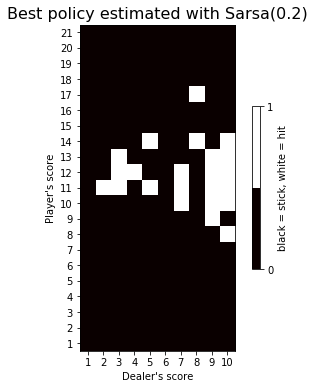

In [25]:
display_best_action_heatmap(sarsa_Q, title="Best policy estimated with Sarsa("+str(lambda_)+")")

We obtain a strategy slightly different. The area of where the best action is to hit is not anymore contiguous which can seem a bit odd.

### V and Q functions

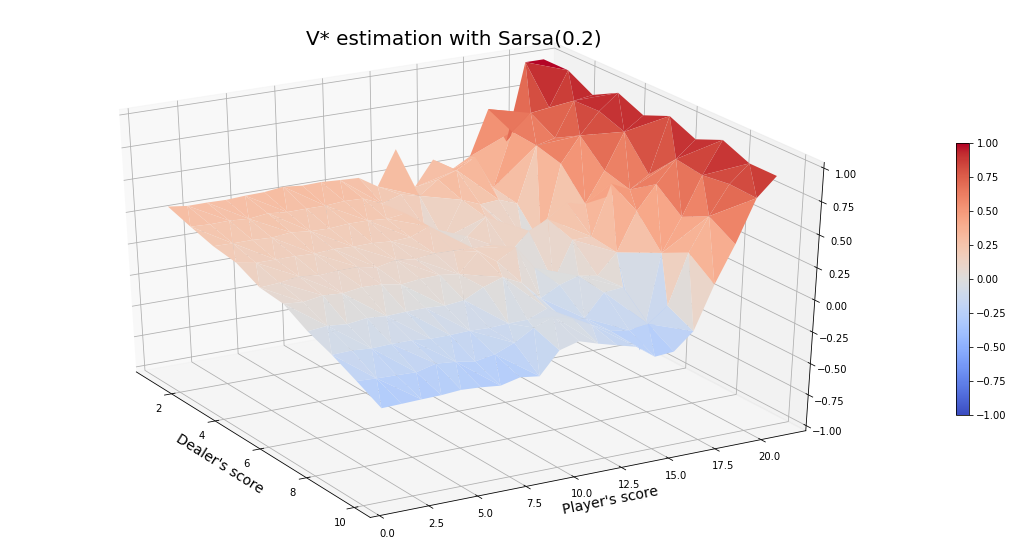

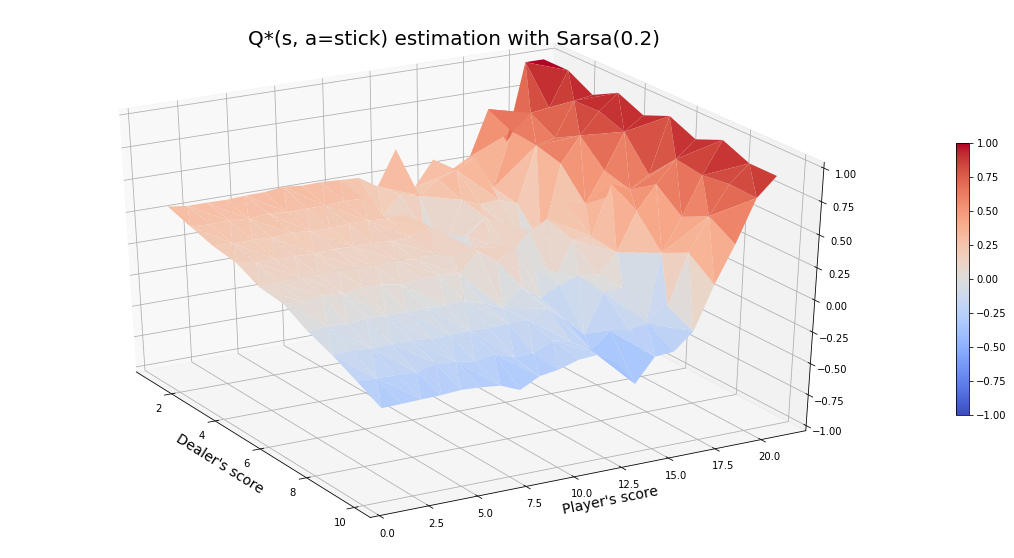

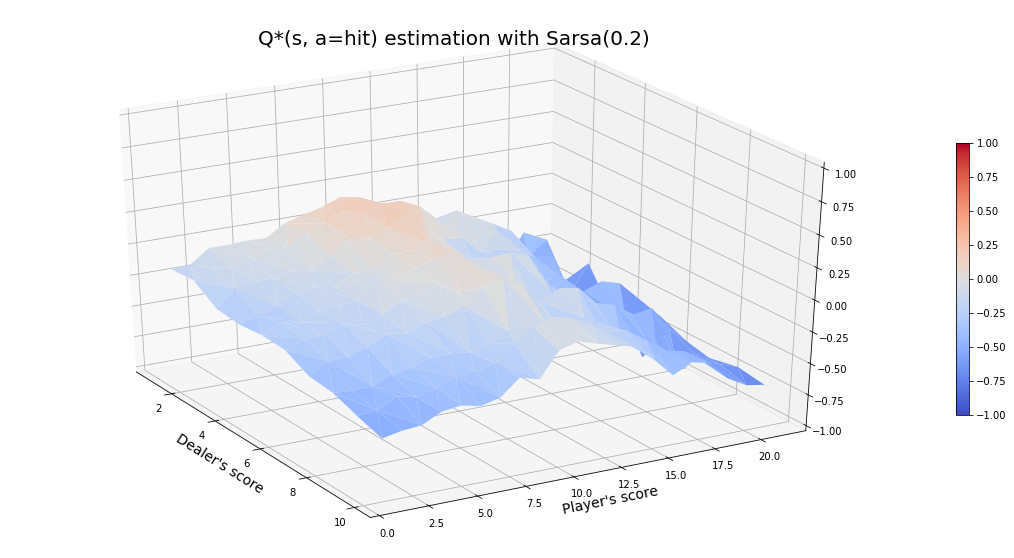

In [27]:
sarsa_df = compute_df(sarsa_Q)
display_3d_representation(sarsa_df,"v_star",title="V* estimation with Sarsa("+str(lambda_)+")")
display_3d_representation(sarsa_df,"q0", title="Q*(s, a=stick) estimation with Sarsa("+str(lambda_)+")")
display_3d_representation(sarsa_df,"q1", title="Q*(s, a=hit) estimation with Sarsa("+str(lambda_)+")")

We obtain results similar to those obtained with Monte-Carlo.

### MSE and convergence

What we can do now is to compute $\dfrac{\sum_{s,a}\left( Q^{s}\left( s,a\right) -Q^{*}\left( s,a\right) \right) ^{2}}{n}$ 

with $Q^{*}\left( s,a\right) = Q^{MC}\left( s,a\right)$ and $n = 21*10*2$, the number of states $*$ the number of actions.

Thus, we can compare the distance between the Q-values we got with Monte-Carlo approach and the Q-values of Sarsa($\lambda$) for different values of $\lambda$.

In [28]:
sarsa_Q_list = list()
sarsa_N_list = list()
sarsa_error_history_list = list()
for l in np.linspace(0,1,11):
    Q_result, N_result, error_history_result = sarsa_lambda(num_episodes = 10**5, 
                                                    N_0 = 100, 
                                                    gamma = 1, 
                                                    lambda_ = l,
                                                    mc_Q = mc_Q)
    sarsa_Q_list.append(Q_result)
    sarsa_N_list.append(N_result)
    sarsa_error_history_list.append(error_history_result)

100%|████████████████████████████████████████████████████████████████████████| 100000/100000 [00:37<00:00, 2685.97it/s]


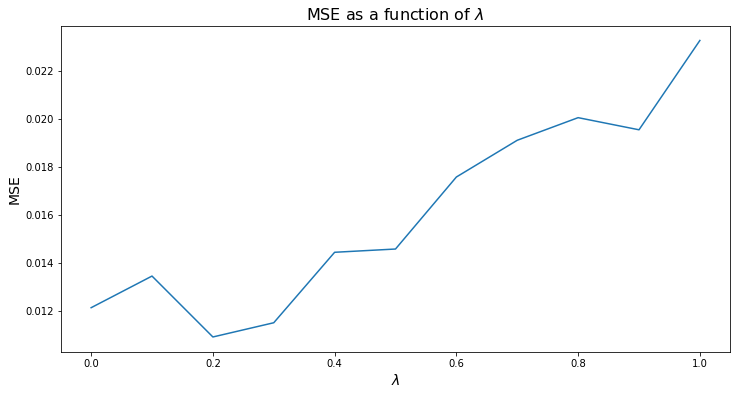

In [29]:
lambda_values = np.linspace(0,1,11)
mse_values = [error_history[-1] for error_history in sarsa_error_history_list]

fig = plt.figure(figsize=(12,6))
plt.plot(lambda_values,mse_values)
plt.xlabel("$\lambda$",size=14)
plt.ylabel("MSE",size=14)
plt.title("MSE as a function of $\lambda$", size = 16)
plt.show()

The MSE is lower for low values of $\lambda$.

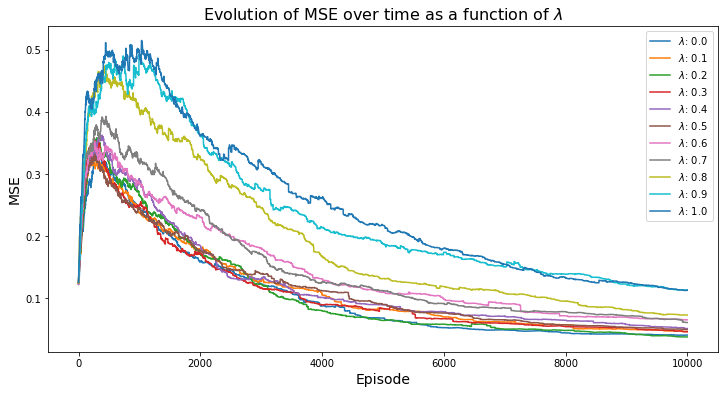

In [30]:
num_episodes = 10**4
num_lambda = len(sarsa_error_history_list)

fig = plt.figure(figsize=(12,6))
for i in range(num_lambda):
    plt.plot(range(num_episodes),sarsa_error_history_list[i][0:num_episodes], label="$\lambda$: " + str(i/10))
plt.legend()

plt.xlabel("Episode",size=14)
plt.ylabel("MSE",size=14)
plt.title("Evolution of MSE over time as a function of $\lambda$", size = 16)
plt.show()

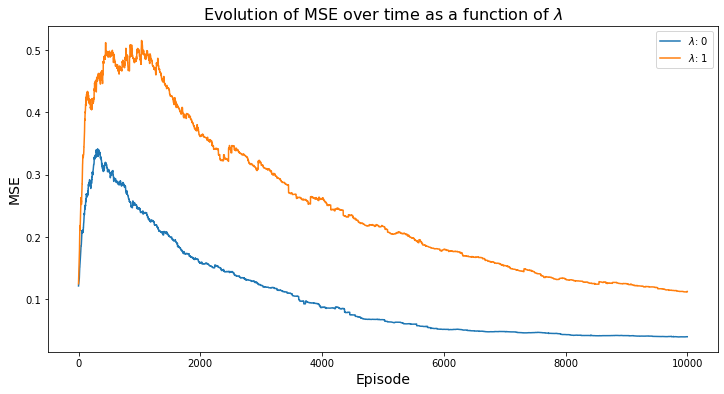

In [31]:
fig = plt.figure(figsize=(12,6))
plt.plot(range(num_episodes),sarsa_error_history_list[0][0:num_episodes], label="$\lambda$: " + str(0))
plt.plot(range(num_episodes),sarsa_error_history_list[10][0:num_episodes], label="$\lambda$: " + str(1))

plt.legend()

plt.xlabel("Episode",size=14)
plt.ylabel("MSE",size=14)
plt.title("Evolution of MSE over time as a function of $\lambda$", size = 16)
plt.show()

With a lower $\lambda$, the algorithm converges faster.

### How the states were explored

#### For $\lambda = 0$

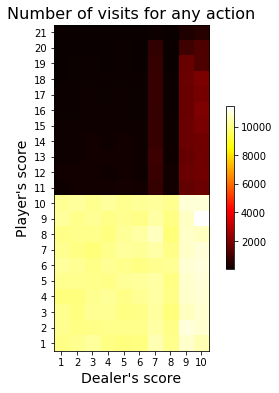

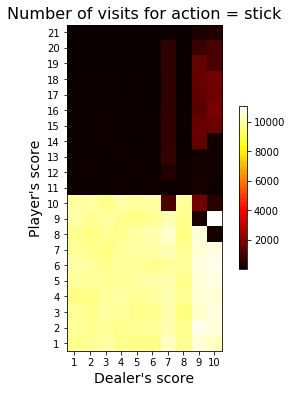

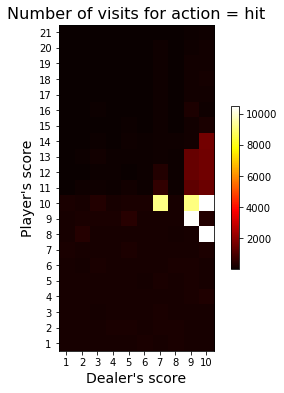

In [32]:
i_lambda = 0
plot_N(np.sum(sarsa_N, axis=2),"Number of visits for any action")
plot_N(sarsa_N[:,:,0],"Number of visits for action = stick")
plot_N(sarsa_N[:,:,1],"Number of visits for action = hit")

#### For $\lambda = 1$

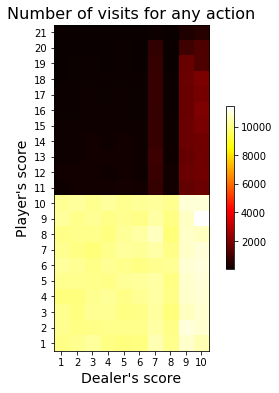

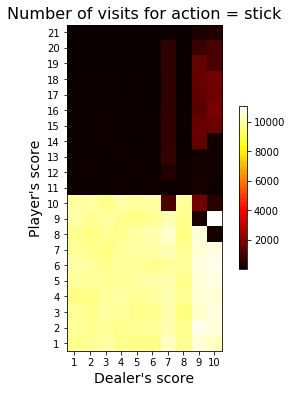

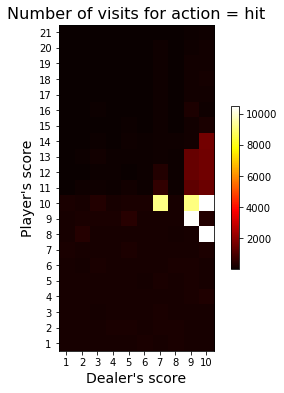

In [33]:
i_lambda = 1
plot_N(np.sum(sarsa_N,axis=2),"Number of visits for any action")
plot_N(sarsa_N[:,:,0],"Number of visits for action = stick")
plot_N(sarsa_N[:,:,1],"Number of visits for action = hit")

We obtain similar results. 

However, we can see that when the dealer's score is 9 or 10, the player will try more often to hit during the training, which results in few more visits for states for which dealer's score is higher than 9.

## 4. Sarsa with Linear Function Approximation <a name="paragraph4"></a>

In this part, we will act as if we did not know the exact scores of player and dealer but we still have some hints about it.

We will know the features of player and dealer as explained hereunder:
* player_feature(s) ={[1,6], [4,9], [7,12], [10,15], [13,18], [16,21]}
* dealer_feature(s) ={[1,4], [4,7], [7,10]}

Example:
If player has a current score of 11, its feature is [0,0,1,1,0,0]

This situation can either occurs:
* if we really cannot get the full information.
* if the environment is too complex to store all the different states (or if we want to have a faster convergence), then we intentionally choose to make the problem easier.

We will apply our previous implementation of Sarsa($\lambda$) to this new problem and as before, we will try to find the optimal policy.

### State update

To begin with, we update our state class which is now able to deal with features.

In [34]:
class State:
    def __init__(self):
        self.player_score = np.random.randint(1, 10+1)
        self.dealer_score = np.random.randint(1, 10+1)
        self.player_features = np.empty(6) #New
        self.dealer_features = np.empty(3) #New
        self.update_approximate_score(init = True) #New       
        
    def __str__(self):
        return "{'player_score': " + str(self.player_score) + \
              ", 'dealer_score': " + str(self.dealer_score) + \
              ", 'player_features': " + np.array_str(self.player_features) + \
              ", 'dealer_features': " + np.array_str(self.dealer_features) + "}"
    
    def isBusted(self, participant):
        '''Check if the participant is busted
        
        Parameters
        ----------
        participant : string
            "player" or "dealer"
            
        Returns
        ----------
        _ : bool
            True if participant's score is lower than 1 or higher than 21
        '''
        
        if (participant == "player"):
            return ( (self.player_score < 1) + (self.player_score > 21) ) >= 1
        elif (participant == "dealer"):
            return ( (self.dealer_score < 1) + (self.dealer_score > 21) ) >= 1
        else:
            print("The participant should be either 'player' or 'dealer'")        
        
    def hit(self, participant, print_card = False):
        '''Draw a card for the participant
        
        Parameters
        ----------
        participant : string
            "player" or "dealer"
        print_card : bool
            Print logs
        '''
        
        if (participant == "player"):
            self.player_score += self.draw(print_card)
        elif (participant == "dealer"):
            self.dealer_score += self.draw(print_card)
        else:
            print("The participant should be either 'player' or 'dealer'")
        self.update_approximate_score() #New

    def dealer_play(self, print_card):
        '''Play the dealer's turn
        
        Parameters
        ----------
        print_card : bool
            Print logs
        '''
        
        while(self.dealer_score < 17):
            self.hit("dealer", print_card)
            if self.isBusted("dealer"):
                break
                
    @staticmethod           
    def draw(print_card):
        '''Define the value of a drawn card
        
        Parameters
        ----------
        print_card : bool
            Print logs
            
        Returns
        ----------
        card_value : int
            Value of the card
        ''' 
        
        color_value = -1 if np.random.rand() < 1 / 3 else 1
        card_value = color_value * np.random.randint(1, 10+1)
        if print_card:
            print("The drawn card has a value of", card_value)
        return card_value
    
    #New
    def update_approximate_score(self, init = False):
        '''Update vectors approximating scores
        
        Parameters
        ----------
        init : bool
            True if dealer's features need to be updated
        ''' 
        self.player_features[0] = ( (self.player_score >= 1) + (self.player_score <= 6) ) == 2      
        self.player_features[1] = ( (self.player_score >= 4) + (self.player_score <= 9) ) == 2 
        self.player_features[2] = ( (self.player_score >= 7) + (self.player_score <= 12) ) == 2 
        self.player_features[3] = ( (self.player_score >= 10) + (self.player_score <= 15) ) == 2 
        self.player_features[4] = ( (self.player_score >= 13) + (self.player_score <= 18) ) == 2 
        self.player_features[5] = ( (self.player_score >= 16) + (self.player_score <= 21) ) == 2 
        
        if init:
            self.dealer_features[0] = ( (self.dealer_score >= 1) + (self.dealer_score <= 4) ) == 2
            self.dealer_features[1] = ( (self.dealer_score >= 4) + (self.dealer_score <= 7) ) == 2
            self.dealer_features[2] = ( (self.dealer_score >= 7) + (self.dealer_score <= 10) ) == 2

### Try the environment

In [35]:
env = Easy21World()

In [36]:
print(env.s)

{'player_score': 3, 'dealer_score': 5, 'player_features': [1. 0. 0. 0. 0. 0.], 'dealer_features': [0. 1. 0.]}


In [37]:
env.step("hit",True)

Player hits
The drawn card has a value of 8
{'player_score': 11, 'dealer_score': 5, 'player_features': [0. 0. 1. 1. 0. 0.], 'dealer_features': [0. 1. 0.]}


0

In [38]:
env.step("stick",True)

Player sticks
The drawn card has a value of 6
The drawn card has a value of 4
The drawn card has a value of 1
The drawn card has a value of 2
{'player_score': 11, 'dealer_score': 18, 'player_features': [0. 0. 1. 1. 0. 0.], 'dealer_features': [0. 1. 0.]}


-1

In [39]:
print(env.s)

{'player_score': 11, 'dealer_score': 18, 'player_features': [0. 0. 1. 1. 0. 0.], 'dealer_features': [0. 1. 0.]}


### Implementation

<img src="img/linear_approx_update.png" width=500>

In [40]:
def compute_features_vector (player_features, dealer_features, action):
    '''Create a vector 'features' where features[i+6*j+6*3*a] = player_features[i] * dealer_features[j] + 6*3*a 
    
    Parameters
    ----------
    player_features : np.array(bool)
        Features of the player
    dealer_features : np.array(bool)
        Features of the dealer
    action : bool
        Action
        
    Returns
    ----------
    features : np.array    
        Features vector representing the state and the action    
    '''
    features = np.dot(dealer_features[:,None],player_features[None,:]).flatten()
    actions = np.array([1-action, action])
    features = np.dot(actions[:,None],features[None,:]).flatten()
    return features

def compute_Q_approx(player_features, dealer_features, action, theta):
    '''Compute an approximation of Q 
    
    Parameters
    ----------
    player_features : np.array(bool)
        Features of the player
    dealer_features : np.array(bool)
        Features of the dealer
    action : bool
        Action
    theta : np.array
        Theta vector
        
    Returns
    ----------
    _ : float    
        Approximation of Q(dealer_features, dealer_features, action, theta)
    '''
    
    features = compute_features_vector(player_features, dealer_features, action)   
    return np.sum(features * theta)

def constant_epsilon_greedy(epsilon, player_features, dealer_features, theta):
    '''Determines which action should be played

    Parameters
    ----------
    epsilon : float
        Epsilon parameter
    player_features : np.array(bool)
        Features of the player
    dealer_features : np.array(bool)
        Features of the dealer
    theta : np.array
        Theta vector
        
    Returns
    ----------
    action : bool
        Value of the action to be played
    '''
       
    action = "None"
    if np.random.random() < epsilon:
        action = np.random.randint(0, 1+1)
    else:
        if compute_Q_approx(player_features, dealer_features, 0, theta) > \
           compute_Q_approx(player_features, dealer_features, 1, theta):
            action = 0
        else:
            action = 1
    return action

def compute_player_features(player_score):
    '''Create a vector 'features' for the player 
    
    Parameters
    ----------
    player_score : int
        Score of the player
        
    Returns
    ----------
    player_features : np.array    
        Features vector representing the player's score    
    '''    
    
    player_features = np.zeros(6)
    
    player_features[0] = ( (player_score >= 1) + (player_score <= 6) ) == 2      
    player_features[1] = ( (player_score >= 4) + (player_score <= 9) ) == 2 
    player_features[2] = ( (player_score >= 7) + (player_score <= 12) ) == 2 
    player_features[3] = ( (player_score >= 10) + (player_score <= 15) ) == 2 
    player_features[4] = ( (player_score >= 13) + (player_score <= 18) ) == 2 
    player_features[5] = ( (player_score >= 16) + (player_score <= 21) ) == 2 
    
    return player_features
    
def compute_dealer_features(dealer_score):
    '''Create a vector 'features' for the dealer 
    
    Parameters
    ----------
   dealer_score : int
        Score of the player
        
    Returns
    ----------
    dealer_features : np.array    
        Features vector representing the dealer's score    
    '''  
    
    dealer_features = np.zeros(3)
    
    dealer_features[0] = ( (dealer_score >= 1) + (dealer_score <= 4) ) == 2
    dealer_features[1] = ( (dealer_score >= 4) + (dealer_score <= 7) ) == 2
    dealer_features[2] = ( (dealer_score >= 7) + (dealer_score <= 10) ) == 2    
    
    return dealer_features
    
def compute_Q_score_table(theta):
    '''Create Q table as if we knew the score of the player and the dealer from the knowledge of theta

    Parameters
    ----------
    theta : np.array
        Theta vector
        
    Returns
    ----------
    Q : np.array
        Q-function    
    '''
    
    Q = np.zeros([21, 10, 2])
    for player_score in range(1, 21+1):
        player_features = compute_player_features(player_score)
        for dealer_score in range(1, 10+1):
            dealer_features = compute_dealer_features(dealer_score)
            for action in range(1+1):
                Q[player_score-1, dealer_score-1, action] = compute_Q_approx(player_features, dealer_features, action, theta)
                
    return Q

def sarsa_lambda_with_linear_approximation(num_episodes, gamma, lambda_, alpha = 0.01, epsilon = 0.05, mc_Q = None):
    '''Implements Sarsa(lambda) algorithm with linear approximation
    
    Parameters
    ----------
    num_episode : int
        Number of episodes
    gamma : float
        Update parameter
    lambda_ : float
        Sarsa parameter
    alpha : float
        Sarsa parameter
    epsilon : float
        Epsilon parameter        
    mc_Q : np.array
        Q-function (computed with MC algorithm)
        
    Returns
    ----------
    Q : np.array
        Q-function
    N : np.array(int)
        Number of time each state N[p,d,a] has been visited
    error_history : list(float)
        Evolution of the MSE (between Q and mc_Q)
    ''' 
    
    # Initialize empty arrays
    error_history = list()
    theta = np.zeros(6*3*2)
    N = np.zeros(6*3*2)   
    
    for i_episode in tqdm(range(num_episodes)):
        
        # Initialize E array  
        E = np.zeros(6*3*2)
        
        # Create a new environment (initialize S)
        env = Easy21World()

        # Choose first action (initialize A)
        player_features = copy.deepcopy(env.s.player_features)
        dealer_features = env.s.dealer_features 
        action = constant_epsilon_greedy(epsilon, player_features, dealer_features, theta)  
        
        # Infinite loop
        while True:              
            # Run one timestep of the environment's dynamics (take action A, observe R, S')            
            reward = env.step(action)
            next_player_features = copy.deepcopy(env.s.player_features)
            
            if env.isGameOver:
                next_action = "None"
                delta = reward - compute_Q_approx(player_features, dealer_features, action, theta)
            else:
                # Choose next action A'
                next_action = constant_epsilon_greedy(epsilon, next_player_features, dealer_features, theta)
                
                # Compute delta
                delta = reward \
                        + gamma * compute_Q_approx(next_player_features, dealer_features, next_action, theta) \
                        - compute_Q_approx(player_features, dealer_features, action, theta)
            
            # Update the knowledge (E and theta)
            E = gamma * lambda_ * E + compute_features_vector(player_features, dealer_features, action)
            N += compute_features_vector(player_features, dealer_features, action)
            theta += (alpha * delta * E)
            
            # If terminal state then break the loop
            if env.isGameOver:
                break

            # Update next action and next player_score
            player_features = copy.deepcopy(next_player_features)
            action = next_action
        
        # Add error_history
        if (mc_Q is not None):
            Q = compute_Q_score_table(theta)
            error_history.append(np.mean((Q - mc_Q)**2)) 
    
    if (mc_Q is not None):
        return Q, N, error_history, theta
    
    Q = compute_Q_score_table(theta)
    return Q, N, theta



### Best Action Heatmap

Now that the implementation is ready, it is time to compute a Sarsa(0.2) with linear approximation and find out what the best policy is.

In [41]:
lambda_ = 0.2
sarsa_la_Q, sarsa_la_N, sarsa_la_theta = sarsa_lambda_with_linear_approximation(10**5, 
                                                                  gamma = 1, 
                                                                  lambda_ = lambda_, 
                                                                  alpha = 0.01, 
                                                                  epsilon = 0.05) 

100%|████████████████████████████████████████████████████████████████████████| 100000/100000 [00:34<00:00, 2861.82it/s]


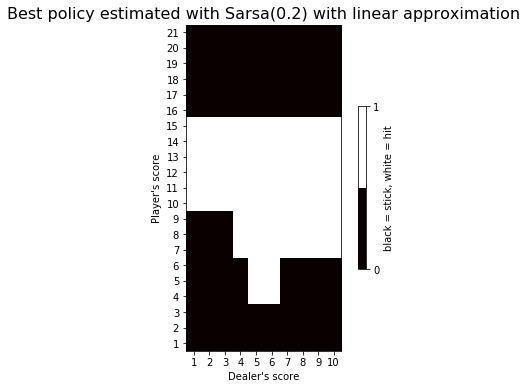

In [42]:
display_best_action_heatmap(sarsa_la_Q, title="Best policy estimated with Sarsa("+str(lambda_)+") with linear approximation")

With a linear approximation, the best policy changes (since our information is less accurate) and player plays "stick" more often. However, for high and low player's score, the best action remains to stick.

### V and Q functions

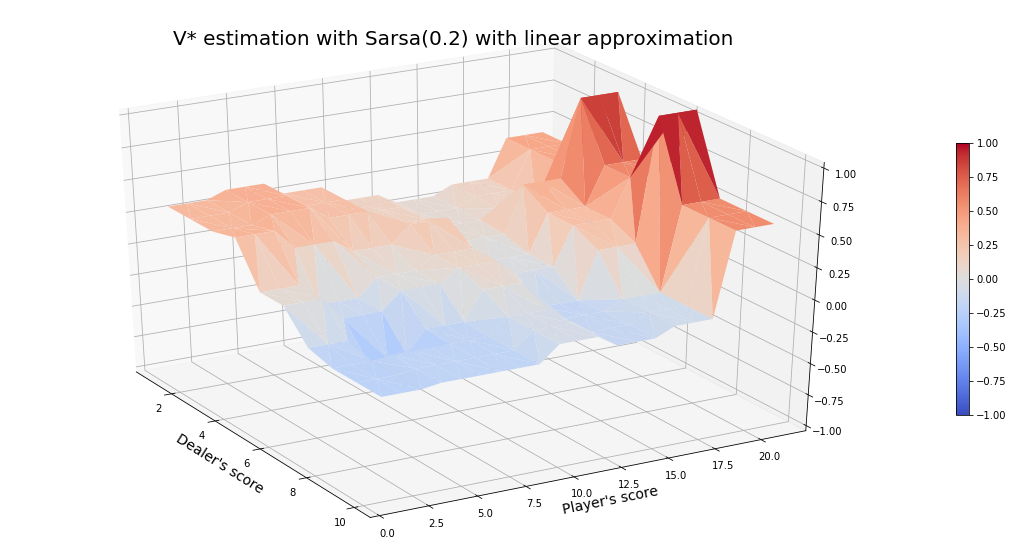

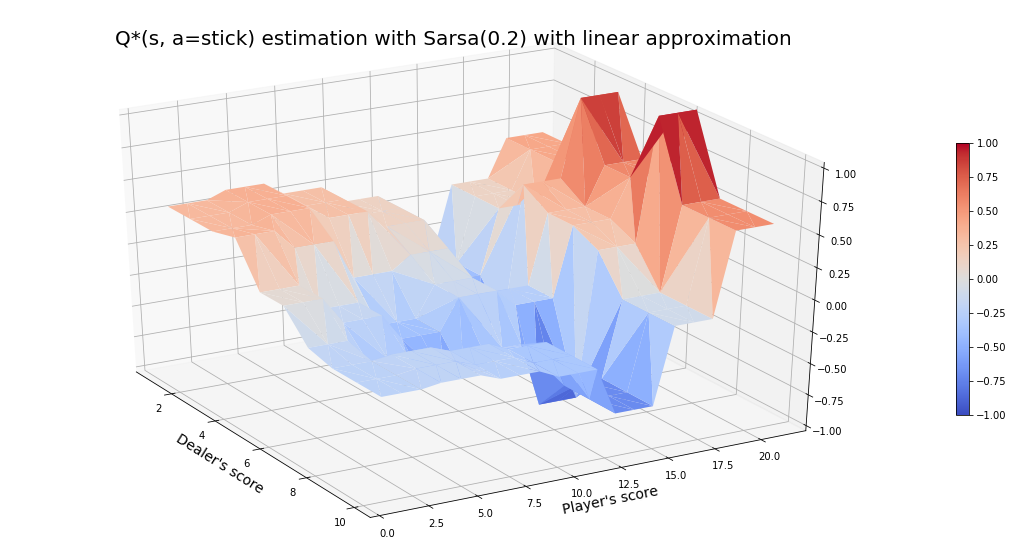

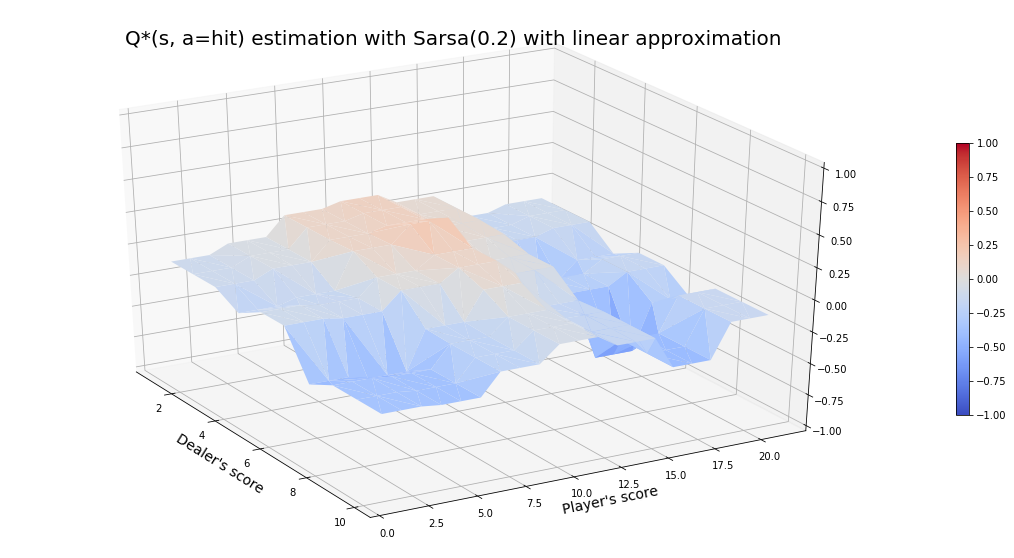

In [43]:
sarsa_la_df = compute_df(sarsa_la_Q)
display_3d_representation(sarsa_la_df,"v_star",title="V* estimation with Sarsa("+str(lambda_)+") with linear approximation")
display_3d_representation(sarsa_la_df,"q0", title="Q*(s, a=stick) estimation with Sarsa("+str(lambda_)+") with linear approximation")
display_3d_representation(sarsa_la_df,"q1", title="Q*(s, a=hit) estimation with Sarsa("+str(lambda_)+") with linear approximation")

### MSE and convergence

In [44]:
sarsa_la_Q_list = list()
sarsa_la_N_list = list()
sarsa_la_error_history_list = list()
sarsa_la_theta_list = list()
for l in np.linspace(0,1,11):
    Q_result, N_result, error_history_result, theta_result = sarsa_lambda_with_linear_approximation(
                                                                                num_episodes = 10**4,  
                                                                                gamma = 1,
                                                                                lambda_ = l,
                                                                                alpha = 0.01,
                                                                                epsilon = 0.05,
                                                                                mc_Q = mc_Q)
    sarsa_la_Q_list.append(Q_result)
    sarsa_la_N_list.append(N_result)
    sarsa_la_error_history_list.append(error_history_result)
    sarsa_la_theta_list.append(theta_result)

100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [01:28<00:00, 112.75it/s]


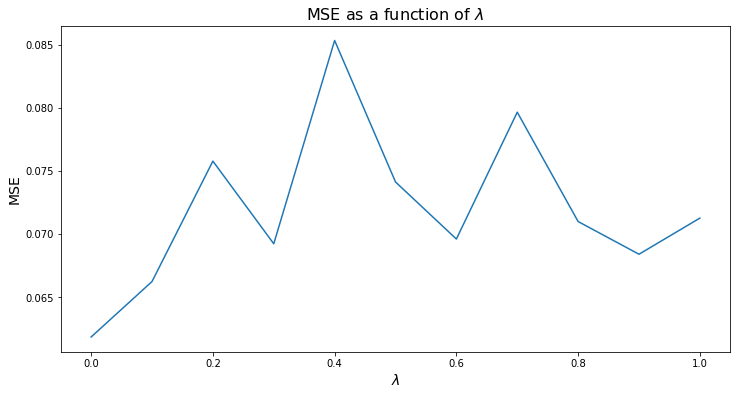

In [45]:
lambda_values = np.linspace(0,1,11)
mse_values = [error_history[-1] for error_history in sarsa_la_error_history_list]

fig = plt.figure(figsize=(12,6))
plt.plot(lambda_values,mse_values)
plt.xlabel("$\lambda$",size=14)
plt.ylabel("MSE",size=14)
plt.title("MSE as a function of $\lambda$", size = 16)
plt.show()

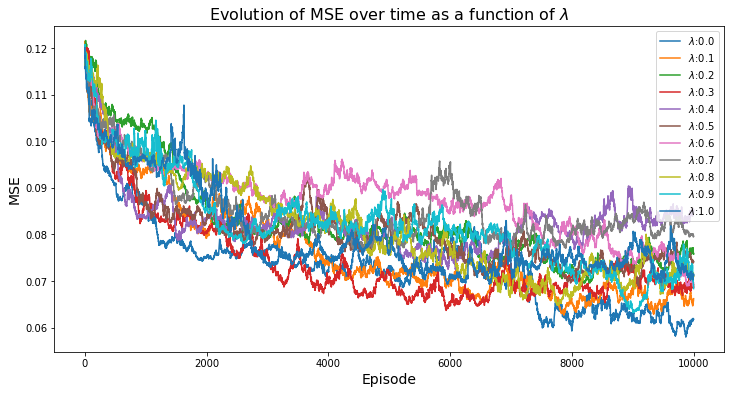

In [46]:
num_episodes = 10**4
num_lambda = len(sarsa_la_error_history_list)

fig = plt.figure(figsize=(12,6))
for i in range(num_lambda):
    plt.plot(range(num_episodes),sarsa_la_error_history_list[i][0:num_episodes], label="$\lambda$:" + str(i/10))
plt.legend()

plt.xlabel("Episode",size=14)
plt.ylabel("MSE",size=14)
plt.title("Evolution of MSE over time as a function of $\lambda$", size = 16)
plt.show()

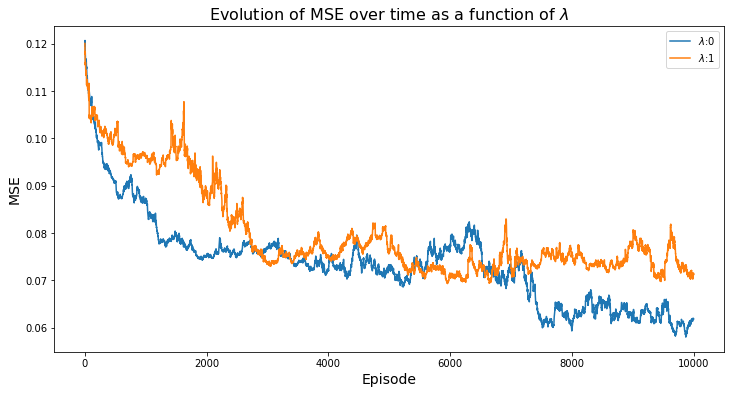

In [47]:
fig = plt.figure(figsize=(12,6))
plt.plot(range(num_episodes),sarsa_la_error_history_list[0][0:num_episodes], label="$\lambda$:" + str(0))
plt.plot(range(num_episodes),sarsa_la_error_history_list[10][0:num_episodes], label="$\lambda$:" + str(1))

plt.legend()

plt.xlabel("Episode",size=14)
plt.ylabel("MSE",size=14)
plt.title("Evolution of MSE over time as a function of $\lambda$", size = 16)
plt.show()

Contrary to a simple Sarsa($\lambda$), here the parameter $\lambda$ seems to be less important for the convergence.

### How the states were explored

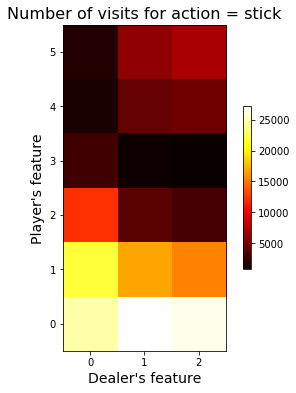

In [48]:
N_stick = sarsa_la_N[0:17+1].reshape(3,6).T

plt.figure(figsize=(6,6))
plt.imshow(N_stick, cmap='hot', origin='lower') 
plt.colorbar(shrink = 0.5)
plt.xlabel("Dealer's feature", size=14)
plt.ylabel("Player's feature", size=14)
plt.title("Number of visits for action = stick", size=16)
plt.show()

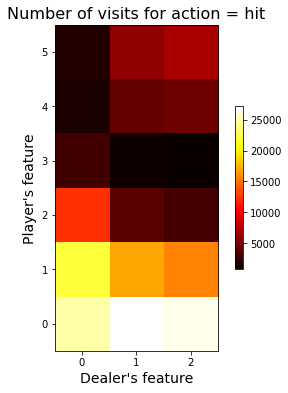

In [49]:
N_hit = sarsa_la_N[18:36+1].reshape(3,6).T

plt.figure(figsize=(6,6))
plt.imshow(N_stick, cmap='hot', origin='lower') 
plt.colorbar(shrink = 0.5)
plt.xlabel("Dealer's feature", size=14)
plt.ylabel("Player's feature", size=14)
plt.title("Number of visits for action = hit", size=16)
plt.show()

We see that we obtain something similar to what we have got before, except it is less accurate (since we use features now).

## 5. Discussion <a name="paragraph5"></a>

#### What are the pros and cons of bootstrapping in Easy21?

Bootstrapping allows a faster convergence (as we saw for Sarsa(0)), but it is biaised.

#### Would  you  expect  bootstrapping  to  help  more  in Blackjack or Easy21? Why?

Episode are longer in average in Easy21. Indeed :
* in Blackjack, you cannot substract points to your score.
* in Blackjack, you have a higher probably to draw a 10 (since pictures count as 10).
* in Blackjack, aces can count for 11 (which can possibly reduce the length of an episode if the player reach a high score with it).

The only case were episodes can be longer in blackjack is when player has a low value card and instantly goes busted.

For this reason, bootstrapping is expected to be more useful in Easy21 whose episodes are more complex.

#### What are the pros and cons of function approximation in Easy21

Function approximation allows to converge faster since there are less states to visit. However, since it is an approximation, if we compare its performance with another algorithm once they both converged, the latter will most likely perform better.

#### How would you modify the function approximator suggested in this section to get better results in Easy21?

A simple way would be to have "bigger" player and dealer features which would be more accurate.
Perhaps, we could also try to choose $\alpha$ and $\epsilon$ decreasing over time in order to reduce the exploration part once we are confident enough on our results.

#### To go further

With more time, and if we wanted to understand more the influence of the parameters, we could have fully analysed the influence of gamma, $N_0$ or $\epsilon$ on the results and/or on the convergence. We could also have plotted Q-function for different values of $\lambda$, or analysed the difference between Q-function for different values of $\lambda$ as well.